In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams, ticker
#from codecarbon import track_emissions
import astropy.coordinates as coord
import astropy.constants as const
import astropy.units as u
from astropy.io import ascii, fits
from astropy.coordinates import SkyCoord
from astropy.cosmology import Planck18
from astropy.convolution import Box1DKernel, Gaussian1DKernel, convolve
from dust_extinction.parameter_averages import G23
import glob
from tqdm import tqdm

# Make use of TeX\ufeff
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
rc('text',usetex=True)
# Change all fonts to 'Computer Modern'
rc('font',**{'size':14, 'family':'serif','serif':['Times New Roman']})
rc('xtick.major', size=5, pad=7)
rc('xtick', labelsize=15)
rc('ytick.major', size=5, pad=7)
rc('ytick', labelsize=15)
rcParams['axes.linewidth'] = 2.5


In [2]:
# Constants
G = 1.32383e-61 # cm eV^-1

# Conversions
deg_to_rad = np.pi/180
rad_to_deg = 1/deg_to_rad
arcmin_to_rad = deg_to_rad/60
rad_to_arcmin = 1/arcmin_to_rad
rad_to_arcsec = rad_to_arcmin*60
K_to_eV = 8.61733e-5
eV_to_Inv_s = 1.51927e15
eVtoInvYr = 4.79e22
cm_to_eV = 50677.3   # /(2*np.pi)
m_to_eV = cm_to_eV*100
eV_to_m = m_to_eV   # *(2*np.pi)
eV_to_Ang = eV_to_m*1e-10
eV_to_mum = eV_to_m*1e-6
g_to_eV = 5.60959e32
kg_to_eV = g_to_eV*1000
eV_to_kg = 1/kg_to_eV
eV_to_g = 1/g_to_eV
s_to_eV = 1.51927e15  # /(2*np.pi)
eV_to_s = s_to_eV  # *(2*np.pi)
yr_to_s = 365*24*3600
yr_to_eV = yr_to_s*s_to_eV
eV_to_yr = yr_to_eV
angstromInv_to_eV = 1973.27   # *(2*np.pi)
eV_to_J = 1.60218e-19
eV_to_erg = eV_to_J*1e7
J_to_eV = 1/eV_to_J
J_to_cm = 3.16303e23   # /(2*np.pi)
kpc_to_cm = 3.086e21
Mpc_to_cm = kpc_to_cm*1000
Msun_to_eV =1.11542e66
flux_to_Jy = 1/(const.c.value*1e10) * 1e23

# Data directory
data_dir = "/home/anirban/Documents/axion_decay/data/"

In [3]:
# Downloaded galaxies. Need to update this dictionary as more data is loaded.
d = {"GS-z10-0": {"RA": "03:32:38.12", "DEC": "−27:46:24.6", "z_spec": 10.38, "M_star/M_sun": 2*10**8},
    "GS-z11-0": {"RA": "12:36:25.46", "DEC": "+62:14:31.4", "z_spec": 11.58, "M_star/M_sun": 1.2*10**9},
    "GS-z12-0": {"RA": "03:32:39.92", "DEC": "−27:49:17.6", "z_spec": 12.63, "M_star/M_sun": 4.3*10**8},
    "GS-z13-0": {"RA": "03:32:35.97", "DEC": "−27:46:35.4", "z_spec": 13.2, "M_star/M_sun": 5.1*10**7},
    "CEERS2_588": {"RA": "14:19:37.59", "DEC": "+52:56:43.8", "z_spec": 11.04, "M_star/M_sun": 10**9},
    "CEERS_99715": {"RA": "14:19:14.84", "DEC": "+52:44:13.6", "z_spec": 10.01, "M_star/M_sun": 1e9},
     "CEERS_35590": {"RA": "14:18:55.81", "DEC": "+52:45:29.1", "z_spec": 9.97, "M_star/M_sun": 1e9}
    }

galaxy_ids = list(d.keys())
print(galaxy_ids)

#with open("galaxy_list.json","w") as f:
 #   json.dump(d,f)
    
# Relation between stellar mass & DM halo mass
Mstar_to_Mhalo = 5

['GS-z10-0', 'GS-z11-0', 'GS-z12-0', 'GS-z13-0', 'CEERS2_588', 'CEERS_99715', 'CEERS_35590']


In [4]:
# Distant halo, when telescope footprint is bigger than the galaxy's angular size
def D_factor_full(halo_params): # M_vir[M_sun], z
    M_vir, z = halo_params
    M_vir *= Msun_to_eV
    d_c = Planck18.comoving_distance(z).value* Mpc_to_cm
    return M_vir/d_c**2 

def line_gaussian(lam, lam0, w):
    return 1/w/np.sqrt(2*np.pi) * np.exp(-(lam-lam0)**2/w/w/2)

# Load the galaxy dictionary
with open("galaxy_list.json") as f:
    d = json.load(f)

# Calculate the ALP decay flux
def alp_flux_EG(xx, ga, ma, galaxy_id):
    '''
    Input:
        xx: wavelength [Angstrom]
        ga: ALP coupling [GeV^-1]
        ma: ALP mass [eV]
        halo_params: halo mass [M_Sun], redshift
    Ouput:
        Flux [erg s^-1 cm^-2 Angstrom^-1]
    '''
    z = d[galaxy_id]["z_spec"]
    d_L = Planck18.luminosity_distance(z).value
    d_c = Planck18.comoving_distance(z).value
    halo_params = [d[galaxy_id]["M_star/M_sun"]*Mstar_to_Mhalo, z]

    #xx *= (1+z)
    ga *= 1e-9 # eV^-1
    Gamma = ga*ga*ma**3/64/np.pi
    ma_lambda = (ma * u.eV/2/(1+z)).to(u.Angstrom, equivalencies=u.spectral()).value
    d_lambda = 200/const.c.to('km/s').value
    wl = np.sqrt((ma_lambda*d_lambda)**2 + (ma_lambda/100/2/np.sqrt(2*np.log(2)))**2) # CLEAR PRISM R=100
    #print(ma_lambda)
    res = Gamma*eV_to_s/8/np.pi*pow(d_c/d_L,2)* D_factor_full(halo_params)*eV_to_erg
    res *= 2*line_gaussian(xx,ma_lambda,wl)
    return res

In [5]:
def plot_spectrum(filename, alp_signal=None):
    '''
    Input:
        filename: Spectrum file name (should end with "_x1d.fits")
        alp_signal: pass a list [ma [eV], ga [GeV^-1]] to plot ALP decay signal from the same DM halo
    Ouput:
        Figure
    '''
    fig, ax = plt.subplots(1,1, figsize=(9,5))
    if alp_signal != None:
        dx = 200
        ga, ma = alp_signal
    
    filename = np.atleast_1d(filename)
    for i in range(len(filename)):
        galaxy_id = filename[i].split("/")[0]
        z = d[galaxy_id]["z_spec"]
        instrument = filename[i].split("_")[-2]
        with fits.open(data_dir+filename[i]) as f:
            flux = f[1].data     
            y = (flux["flux"]*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA,
                            equivalencies=u.spectral_density(flux["WAVELENGTH"] *u.micron))
            y = y.value

            yerr = np.sqrt(flux["FLUX_VAR_POISSON"] + flux["FLUX_VAR_RNOISE"])
            yerr = (yerr*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA,
                            equivalencies=u.spectral_density(flux["WAVELENGTH"] *u.micron))
            yerr = yerr.value
            #y =flux["flux"]
            #ax.plot(flux["WAVELENGTH"], y)
            if instrument in ["clear-prism"]:
                ax.fill_between(flux["wavelength"], y-yerr, y+yerr, fc="mediumblue", ec=None, alpha=0.3)
                #ax.errorbar(flux["wavelength"], y, yerr, label=instrument)
                ax.plot(flux["wavelength"], y, label=instrument, color="darkblue", lw=1.5)
            else:
                # Create kernel
                g = Box1DKernel(width=50)
                smooth_spec = convolve(y, g)
                ax.plot(flux["wavelength"], smooth_spec, label=instrument)
            
            if alp_signal != None:
                ax.plot(flux["WAVELENGTH"], alp_flux_EG(flux["WAVELENGTH"]*1e4, ga, ma, galaxy_id), 
                    color="coral", lw=1.6, ls="dashed",
                        label=r"$m_a=$"+str(int(ma))+r"\,eV, $g_{a\gamma}=$"+str(ga)+r"$\,{\rm GeV^{-1}}$")


    ax.axhline(0, color="silver", ls="dotted")
    #ax.set_xlim(1,2)
    ax.set_ylim(-2e-20, 3e-20)
    ax.set_title(galaxy_id)
    ax.set_xlabel(r"Observed wavelength, $\lambda\,\mathrm{[\mu m]}$")
    ax.set_ylabel(r"$F\,\mathrm{[erg\,s^{-1}cm^{-2}\AA^{-1}]}$")

    #f = lambda x: (x*1e4/2/(1+z)*u.Angstrom).to(u.eV, equivalencies=u.spectral()).value
    #g = lambda x: 1/x-1
    #axtop = ax.secondary_xaxis("top", functions=(f,f)) 
    #axtop.set_xlabel(r"$m_a$ [eV]")

    ax.legend(loc="best", ncol=1)
    plt.tight_layout()
    plt.show()
    return

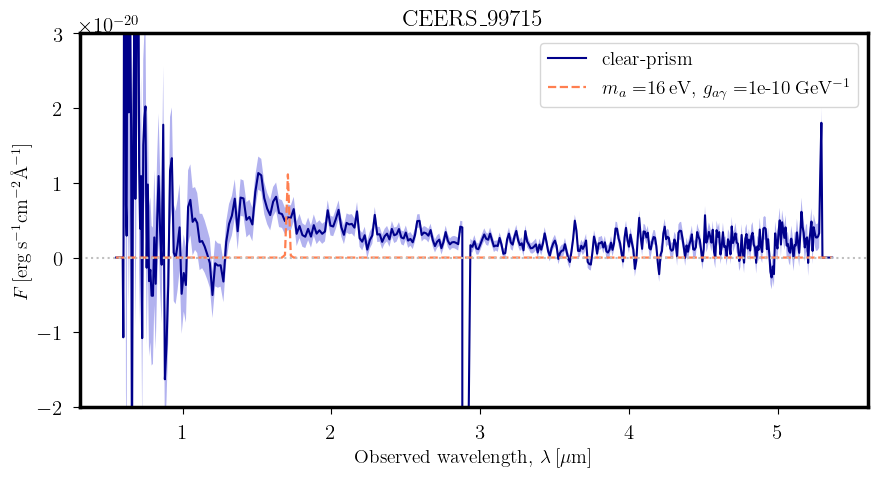

In [7]:
plot_spectrum(["CEERS_99715/jw01345-o102_s80026_nirspec_clear-prism_x1d.fits"], alp_signal=[1e-10,16])

In [8]:
## Functions for chi-square analysis
def total_flux_chisq(ma, ga, galaxy_id, galaxy_spec):
    '''
    Input:
        ma: ALP mass [eV]
        ga: Coupling [GeV^-1]]
        galaxy_id: Galaxy ID
        galaxy_spec: [wavelength [AA], flux, flux_err]
    Ouput:
        chi square
    '''
    xx, flux, flux_err = galaxy_spec[0], galaxy_spec[1], galaxy_spec[2].value
    z = d[galaxy_id]["z_spec"]
    sp = alp_flux_EG(xx, ga, ma, galaxy_id)*u.erg/(u.cm**2*u.AA*u.s)
    # Galactic extinction
    ext = G23(Rv=3.1)
    sp *= ext.extinguish(xx*u.AA, Ebv=0.5)
    tmp = sp.value - (flux* u.erg/(u.cm ** 2 * u.AA * u.s)).value
    res = 0
    for i in range(len(tmp)):
        if not(np.isnan(flux[i])) and not(np.isnan(tmp[i])) and not(np.isnan(flux_err[i])) \
        and flux[i]>=0. and tmp[i]>0:
            res += (tmp[i]/flux_err[i])**2
    return res

def scan_over_mass(malist, filename):
    '''
    Input:
        malist: ALP mass list [eV]
        filename: Spectrum file name (should end with "_x1d.fits")
    Ouput:
        ga upper limit as a list
    '''
    limit = np.ones(len(malist))
    galaxy_id = filename.split("/")[0]
    with fits.open(data_dir+filename) as f:
        datax = f[1].data 
        y = (datax["flux"]*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA,
                        equivalencies=u.spectral_density(datax["WAVELENGTH"] *u.micron))
        yerr = np.sqrt(datax["FLUX_VAR_POISSON"] + datax["FLUX_VAR_RNOISE"])
        yerr = (yerr*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA,
                        equivalencies=u.spectral_density(datax["WAVELENGTH"] *u.micron))
        galaxy_spec = [datax["wavelength"]*1e4, y, yerr]
    galist = np.logspace(-12,-5,num=40)  # Adjust ga range here
    for i,ma in enumerate(tqdm(malist)):
        for ga in galist:
            chisq = total_flux_chisq(ma, ga, galaxy_id, galaxy_spec)
            #print(chisq)
            if chisq > 4:
                limit[i] = ga
                break
    
    # Use the data filename to store the result
    filename = filename.split("/")[1]
    outfile = galaxy_id+filename.split(".")[0]
    np.savetxt("ga_upper-limit_"+outfile+".txt", np.column_stack((malist, limit)), 
               header="m_a [eV],  g_a [GeV^-1]")
    return limit

In [9]:
scan_over_mass(np.linspace(5,30,10), "CEERS_99715/jw01345-o102_s80026_nirspec_clear-prism_x1d.fits")

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


array([1.00000000e+00, 3.25702066e-10, 2.15443469e-10, 1.42510267e-10,
       1.42510267e-10, 9.42668455e-11, 3.66524124e-07, 6.23550734e-11,
       1.60371874e-07, 9.42668455e-11])